**Make sure to include** `import allow_local_imports` on top of every notebook in `notebooks/` dir to be able to use `lib/` modules.

In [13]:
import allow_local_imports

In [14]:
from lib.minority_game_vectorized import VectorizedMinorityGame
from lib.agents.factory_vectorized import VectorizedAgentFactory, VectorizedStrategyUpdatingAgentFactory
from lib.agents.agent import Agent, StrategyUpdatingAgent
from lib.agents.factory import AgentFactory
from lib.strategies import AlwaysOneStrategy, DefaultStrategy, FiftyFiftyStrategy
from lib.memory import UniformMemoryGenerator, GumbelDistributionMemoryGenerator, NormalDistributionMemoryGenerator
from lib.error import MinorityGameError

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma
import seaborn as sns
from numpy.random import default_rng
from numpy.lib.arraysetops import isin
from typing import List
import pandas as pd

## Individual agents

In [5]:
%%time
n_agents = 101
tot_omega_u_orig = []
tot_alpha_u_orig = []
M = 7
times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df = VectorizedMinorityGame(
    n_agents=101,
    factory_dict={
        1: VectorizedAgentFactory(
            memory_generator=UniformMemoryGenerator(M)
        ),
    }
).simulate_game(max_steps=10000, return_individual=True)
# in order to create the graph
omega = np.average(vol_A_t)/n_agents
alpha = 2**M/n_agents
tot_omega_u_orig.append(omega)
tot_alpha_u_orig.append(alpha)

tot_omega_u = np.average(vol_A_t_individual_m_df)/n_agents_m['count'].to_numpy()
tot_alpha_u =  2**n_agents_m['index']/n_agents_m['count']

Wall time: 1.22 s


To test that the individual agent function gives the same as the whole class when only one M value

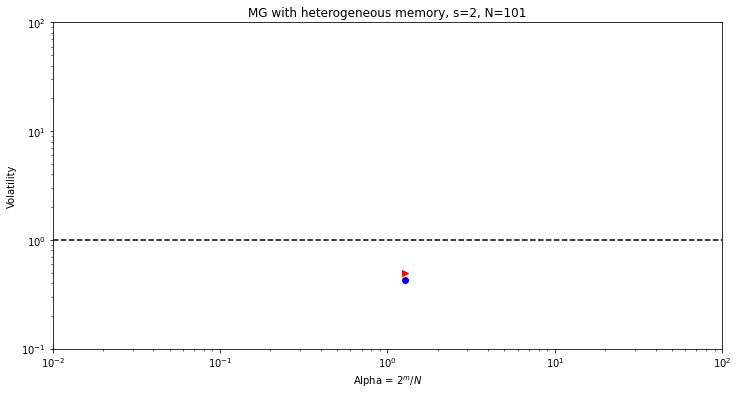

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")

ax.plot(tot_alpha_u, tot_omega_u, 'bo')
ax.plot(tot_alpha_u_orig, tot_omega_u_orig, '>r')

ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

In [7]:
%%time
n_agents = 101
tot_omega_u_orig = []
tot_alpha_u_orig = []
M = 7
times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df = VectorizedMinorityGame(
    n_agents=101,
    factory_dict={
        1: VectorizedAgentFactory(
            memory_generator=NormalDistributionMemoryGenerator(M, 2)
        ),
    }
).simulate_game(max_steps=100, return_individual=True)
# in order to create the graph
omega = np.average(vol_A_t)/n_agents
alpha = 2**M/n_agents
tot_omega_u_orig.append(omega)
tot_alpha_u_orig.append(alpha)

tot_omega_n = np.average(vol_A_t_individual_m_df)/n_agents_m['count']
tot_alpha_n =  2**n_agents_m['index']/n_agents_m['count']

Wall time: 26 ms


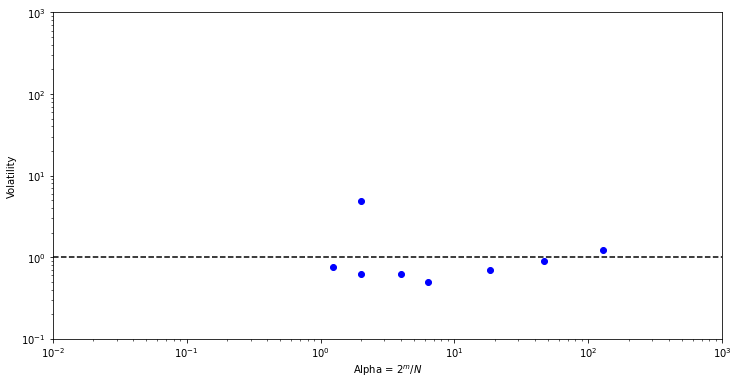

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_n, tot_omega_n, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,1000])
plt.ylim([0.1,1000])

plt.show()

In [9]:
%%time
n_agents = 101 
M = 7
max_steps = 50000


# Gumbel distribution
times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df = VectorizedMinorityGame(
    n_agents=101,
    factory_dict={
        1: VectorizedAgentFactory(
            memory_generator=GumbelDistributionMemoryGenerator(M, 2)
        ),
    }
).simulate_game(max_steps=max_steps, return_individual=True)
m_list_g = n_agents_m['index']
tot_omega_g = np.average(vol_A_t_individual_m_df)/n_agents_m['count']
tot_alpha_g =  2**m_list_g/n_agents_m['count']

#Normal distribution
times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df = VectorizedMinorityGame(
    n_agents=101,
    factory_dict={
        1: VectorizedAgentFactory(
            memory_generator=NormalDistributionMemoryGenerator(M, 2)
        ),
    }
).simulate_game(max_steps=max_steps, return_individual=True)
m_list_n = n_agents_m['index']
tot_omega_n = np.average(vol_A_t_individual_m_df)/n_agents_m['count']
tot_alpha_n =  2**m_list_n/n_agents_m['count']

# Uniform distribution (from the standard minority game class to compare)
tot_omega_u = []
tot_alpha_u = []
m_list_u = []
for M in range (2,15):
    times, attendances, mean_A_t, vol_A_t = VectorizedMinorityGame(
        n_agents=n_agents,
        factory_dict={
            1: VectorizedAgentFactory(
                memory_generator=UniformMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=max_steps, return_mean=True, return_vol=True)
    m_list_u.append(M)
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_u.append(omega)
    tot_alpha_u.append(alpha)

Wall time: 1min 55s


m instead of alpha

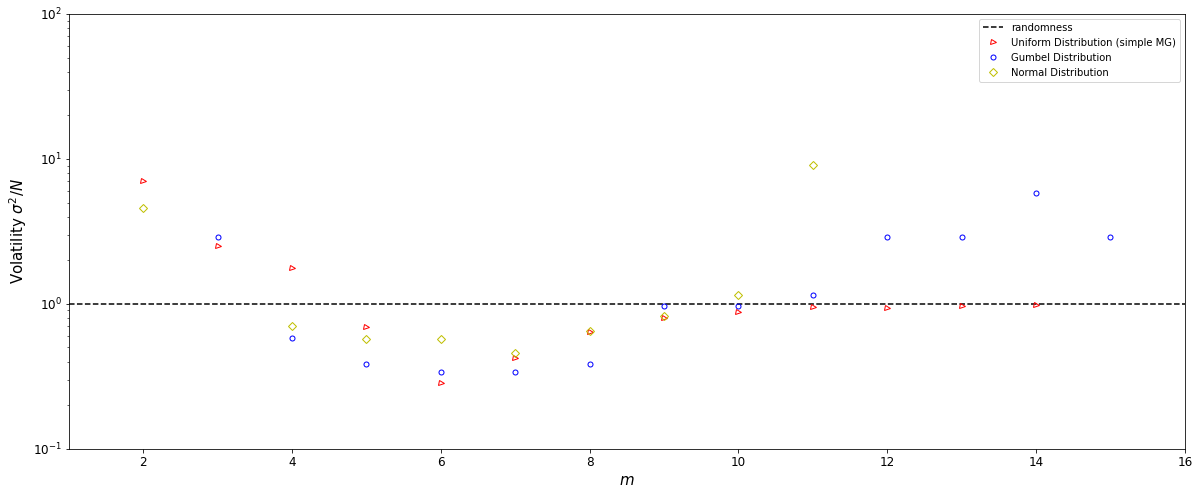

In [10]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness


ax.plot(m_list_u, tot_omega_u, 'r>', mfc = 'None', ms = 5)
ax.plot(m_list_g, tot_omega_g, 'bo', mfc = 'None', ms = 5)
ax.plot(m_list_n, tot_omega_n, 'Dy', mfc = 'None', ms = 5)

plt.ylabel("Volatility $\sigma^2/N$",fontsize=15)
plt.xlabel("$m$",fontsize=15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

# ax.set_xlabel("m")
# ax.set_ylabel("Volatility $\sigma^2/N$")
ax.legend(["randomness","Uniform Distribution (simple MG)","Gumbel Distribution", "Normal Distribution"])

plt.yscale('log')
plt.xlim([1,16])
plt.ylim([0.1,100])
plt.savefig('out/distributionIndividualM_empty.png', dpi=300, bbox_inches='tight')

plt.show()

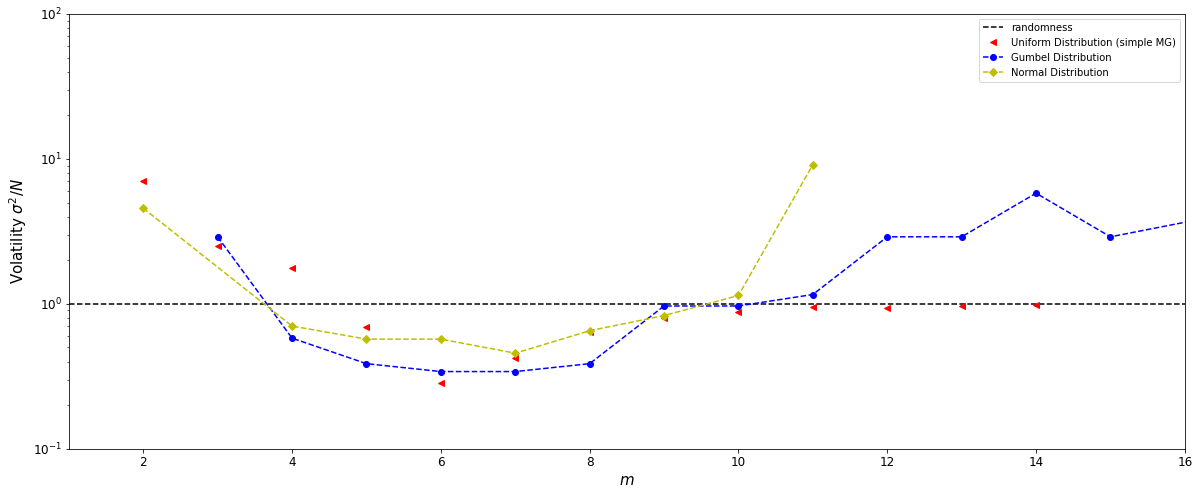

In [11]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness

ax.plot(m_list_u, tot_omega_u, 'r<')
ax.plot(m_list_g, tot_omega_g, 'bo', linestyle="--")
ax.plot(m_list_n, tot_omega_n, 'Dy', linestyle="--")
ax.legend(["randomness","Uniform Distribution (simple MG)","Gumbel Distribution", "Normal Distribution"])

plt.ylabel("Volatility $\sigma^2/N$",fontsize=15)
plt.xlabel("$m$",fontsize=15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.yscale('log')
plt.xlim([1,16])
plt.ylim([0.1,100])
plt.savefig('out/distributionIndividualM.png', dpi=300, bbox_inches='tight')

plt.show()

alpha

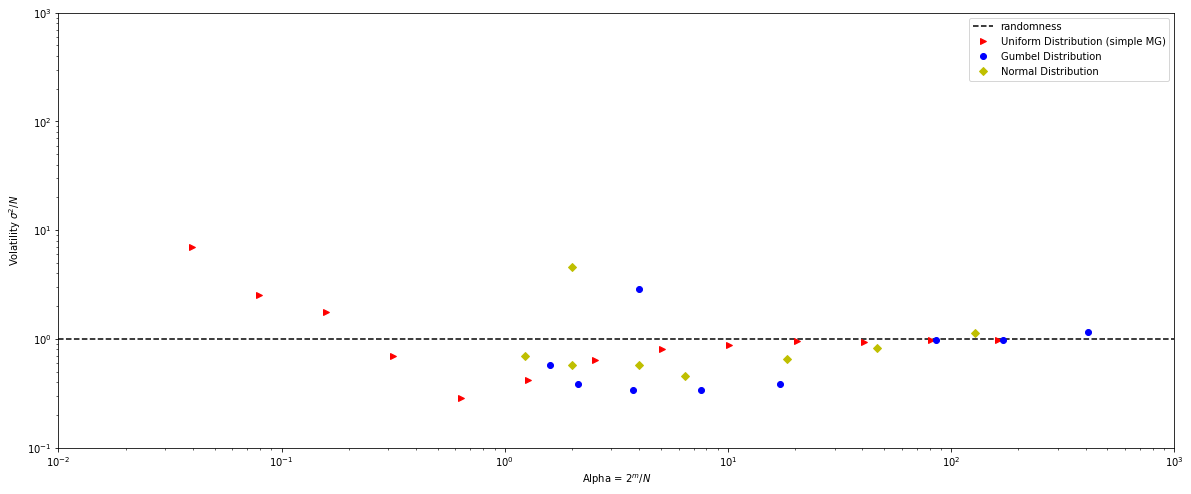

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness

ax.plot(tot_alpha_u, tot_omega_u, '>r')
ax.plot(tot_alpha_g, tot_omega_g, 'bo')
ax.plot(tot_alpha_n, tot_omega_n, 'Dy')

ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility $\sigma^2/N$")
ax.legend(["randomness","Uniform Distribution (simple MG)","Gumbel Distribution", "Normal Distribution"])

plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,1000])
plt.ylim([0.1,1000])
plt.savefig('out/distributionIndividualM_alpha.png', dpi=300, bbox_inches='tight')

plt.show()